# Проект: классификация

In [716]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
import optuna

### Данные о клиентах банка:

* age (возраст);
* job (сфера занятости);
* marital (семейное положение);
* education (уровень образования);
* default (имеется ли просроченный кредит);
* housing (имеется ли кредит на жильё);
* loan (имеется ли кредит на личные нужды);
* balance (баланс).

### Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:

* contact (тип контакта с клиентом);
* month (месяц, в котором был последний контакт);
* day (день, в который был последний контакт);
* duration (продолжительность контакта в секундах).

### Прочие признаки:

* campaign (количество контактов с этим клиентом в течение текущей кампании);
* pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
* previous (количество контактов до текущей кампании)
* poutcome (результат прошлой маркетинговой кампании).

**И, разумеется, наша целевая переменная deposit, которая определяет, согласится ли клиент открыть депозит в банке**

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [653]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')

In [654]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [655]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
df.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

### Задание 2

In [656]:
# Есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
missing_values = df['job'].value_counts()

print(missing_values)

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64


### Задание 3

In [657]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
display(df['balance'].head())

0     2 343,00 $ 
1        45,00 $ 
2     1 270,00 $ 
3     2 476,00 $ 
4       184,00 $ 
Name: balance, dtype: object

In [658]:
# Убираем символ доллара, пробелы и запятую, заменяя запятую на точку
df['balance'] = df['balance'].str.replace(r'\$|\s+', '', regex=True).str.replace(',', '.', regex=False).astype(float)

# Этот код удаляет символ доллара и пробелы, а затем заменяет запятую на точку, что позволит корректно преобразовать значения в float.

In [659]:
average_balance = round(df['balance'].mean(), 3)
print(average_balance)

1529.129


### Задание 4

In [660]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
# Заменяем пропуски в столбце 'balance' на медианное значение
df['balance'] = df['balance'].fillna(df['balance'].median())

# Вычисляем среднее значение и округляем до 3 знаков после запятой
av_balance = round(df['balance'].mean(), 3)
print(av_balance)

1526.936


### Задание 5

In [661]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
# Заменяем пропуски в столбцах 'job' и 'education' на модальные значения
df['job'] = df['job'].fillna(df['job'].mode()[0])
df['education'] = df['education'].fillna(df['education'].mode()[0])



# После замены пропусков рассчитайте средний баланс для клиентов с самой популярной работой и самым популярным уровнем образования 
# (т. е. для тех, у кого одновременно самая популярная работа и самое популярное образование). Ответ округлите до трёх знаков после точки-разделителя.
m_job = df['job'].mode()[0]
df['job'] = df['job'].apply(lambda x: m_job if x == 'unknown' else x)


m_education = df['education'].mode()[0]
df['education'] = df['education'].apply(lambda x: m_education if x == 'unknown' else x)


# Фильтруем DataFrame
filtered_df = df[(df['job'] == m_job) & (df['education'] == m_education)]

# Рассчитываем средний баланс
average_balance = round(filtered_df['balance'].mean(), 3)

# Выводим результат
print(average_balance)

1598.883


### Задание 6

Нижняя граница: -2241
Верхняя граница: 4063
Число выбросов по методу Тьюки: 1057
Результирующее число записей: 10105


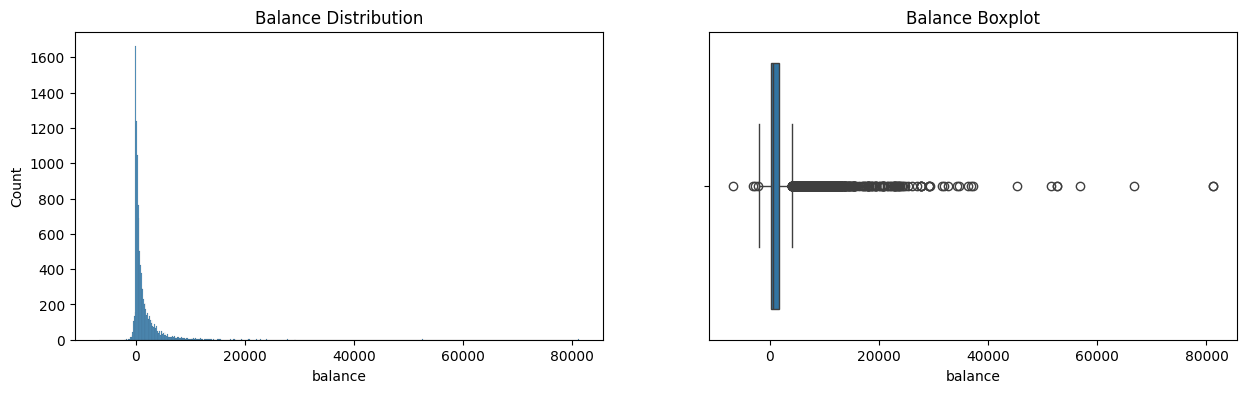

In [662]:
# удалите все выбросы для признака balance
# Построим гистограмму и коробчатую диаграмму для признака полной площади (balance):
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=df, x='balance', ax=axes[0]);
histplot.set_title('Balance Distribution');
boxplot = sns.boxplot(data=df, x='balance', ax=axes[1]);
boxplot.set_title('Balance Boxplot');

# Введите верхнюю и нижнюю границы поиска выбросов по методу Тьюки, округлив их до целых чисел.

# Шаг 1: вычисление квартилей
Q1 = np.percentile(df['balance'], 25)
Q3 = np.percentile(df['balance'], 75)

# Шаг 2: вычисление межквартильного размаха (IQR)
IQR = Q3 - Q1

# Шаг 3: вычисление верхней и нижней границ
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Округление границ до целых чисел
lower_bound = round(lower_bound)
upper_bound = round(upper_bound)

print("Нижняя граница:", lower_bound)
print("Верхняя граница:", upper_bound)

# Фильтрация выбросов
filtered_data = [x for x in df['balance'] if lower_bound <= x <= upper_bound]
#print("Отфильтрованные данные:", filtered_data)

# В соответствии с этим алгоритмом напишем функцию outliers_iqr(). 
# Эта функция принимает на вход DataFrame и признак, по которому ищутся выбросы, а затем возвращает потенциальные выбросы, 
# найденные с помощью метода Тьюки, и очищенный от них датасет.
# Квантили вычисляются с помощью метода quantile(). Потенциальные выбросы определяются при помощи фильтрации данных по условию выхода за 
# пределы верхней или нижней границы.

def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned_df = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned_df

outliers, cleaned_df = outliers_iqr(df, 'balance')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned_df.shape[0]}')

## Часть 2:  Разведывательный анализ

### Задание 1

deposit
no     5424
yes    4681
Name: count, dtype: int64


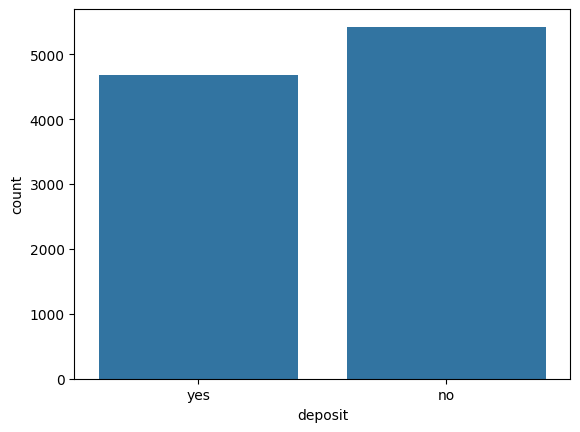

In [663]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
print(cleaned_df['deposit'].value_counts())

sns.countplot(data=cleaned_df, x='deposit');

### Задания 2 и 3

In [664]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
cleaned_df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


**Описательная статистика**

В данном наборе данных представлены семь количественных переменных: возраст (age), баланс (balance), день (day), продолжительность (duration), количество контактов в этом кампании (campaign), количество дней, прошедших с последнего контакта (pdays) и количество предыдущих контактов (previous). Рассмотрим основные статистики для каждой переменной.

**Меры центральной тенденции**

1. Возраст (age):
    * Среднее: 40.9
    * Медиана (50%): 38.0

2. Баланс (balance):
    * Среднее: 807.7
    * Медиана: 445.0

3. Продолжительность (duration):
    * Среднее: 368.7
    * Медиана: 252.0

Можно заметить, что для всех переменных средние значения превышают медианные, что указывает на наличие положительных аномальных значений.

**Меры разброса**

1. Возраст:
    * Стандартное отклонение: 11.7 (широкий диапазон значений).
2. Баланс:
    * Стандартное отклонение: 994.2 (высокая вариативность), при этом минимальное значение -2049 и максимальное 4063 указывают на наличие аномальных значений.
3. Продолжительность:
    * Стандартное отклонение: 346.7. Значительная вариативность указывает на нестабильные значения.

**Минимальные и максимальные значения**

* Возраст варьируется от 18 до 95 лет, что является нормальным диапазоном для большинства популяций.

* Баланс имеет экстремальное минимальное значение (-2049), что явно указывает на ошибку в данных или наличие некоторых клиентов с отрицательным балансом.

* Продолжительность телефонных звонков варьируется от 2 до 3881 секунд, с высокими значениями, которые могут указывать на несколько долгих разговоров.

**Выводы о вариантах данных и аномальных значениях**

Сравнив средние значения и медианы, можно сделать вывод, что диапазон значений для всех переменных велик, с высоким уровнем разброса, особенно для переменной "баланс". Это подсказывает нам, что в данных существуют аномальные значения, как с положительной, так и с отрицательной стороны.

**Рекомендуемые визуализации**

Для дальнейшего анализа будеим использовать следующие визуализации:

* Ящик (box plot) для оценки наличия аномальных значений.

* Гистограммы для наглядного просмотра распределения каждой из переменных.

* Диаграммы рассеяния для выявления возможных зависимостей между переменными, например, между "балансом" и "продолжительностью".

Эти методы позволят лучше понять распределение данных и влияние аномальных значений на общий набор

### Задания 4 и 5

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


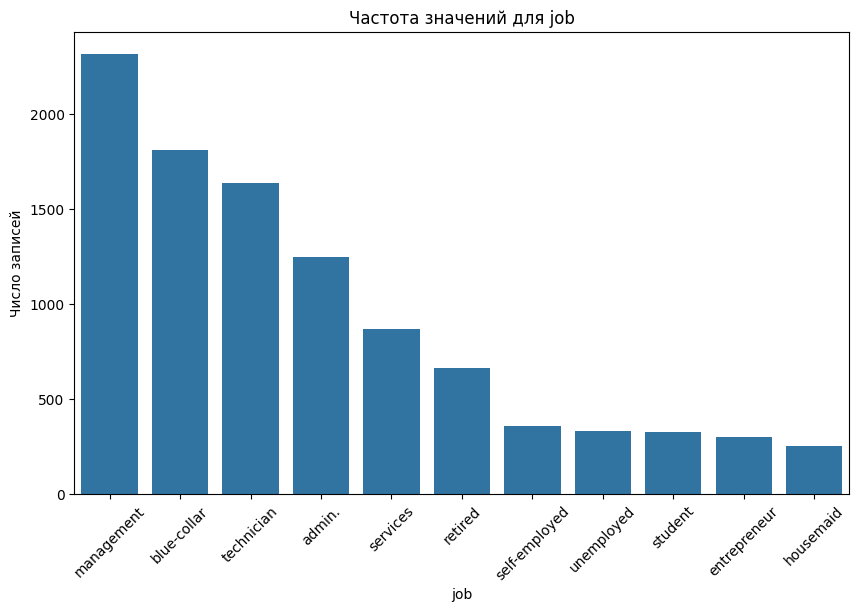

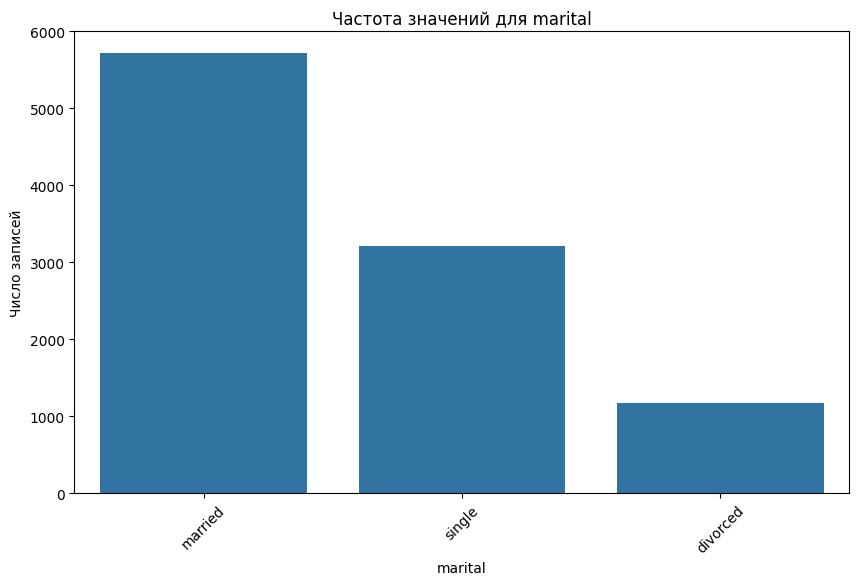

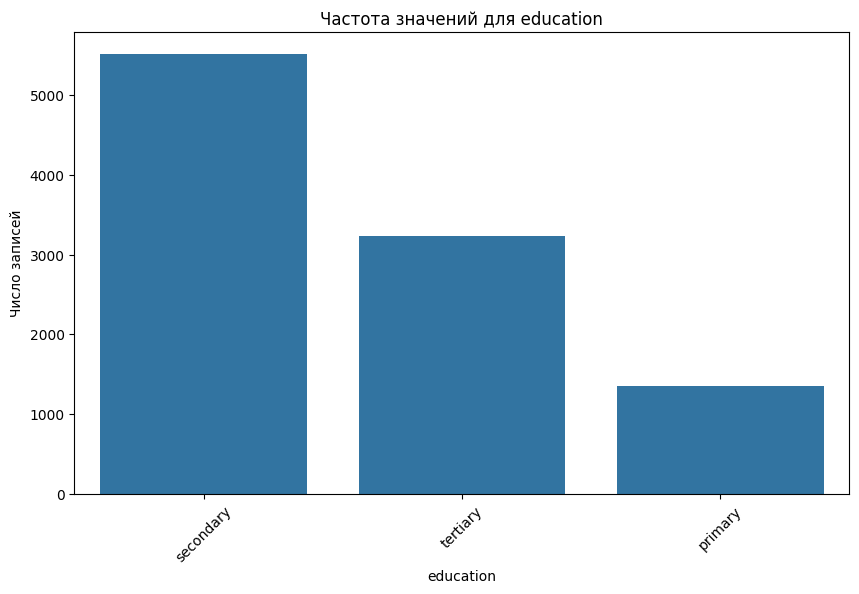

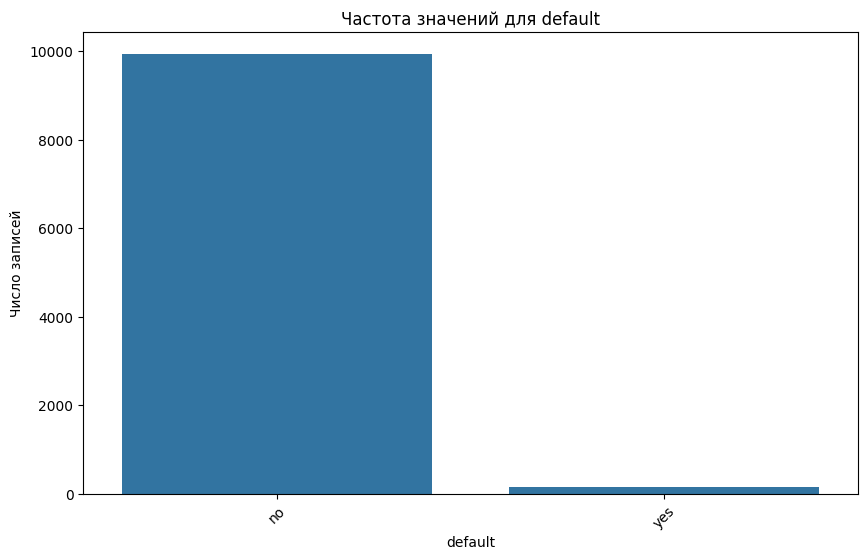

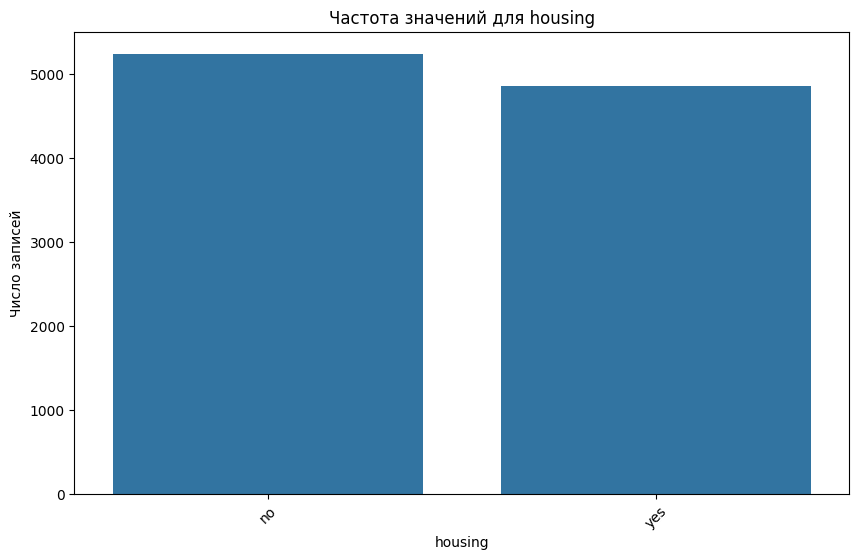

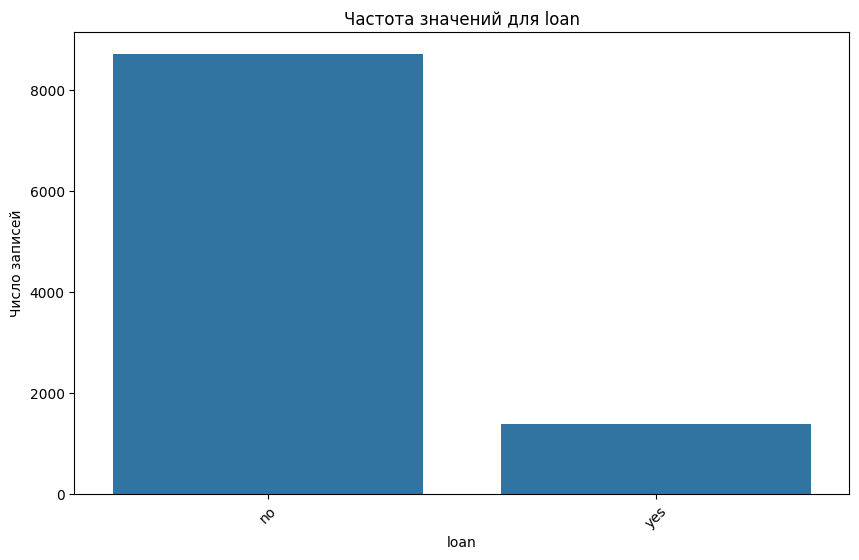

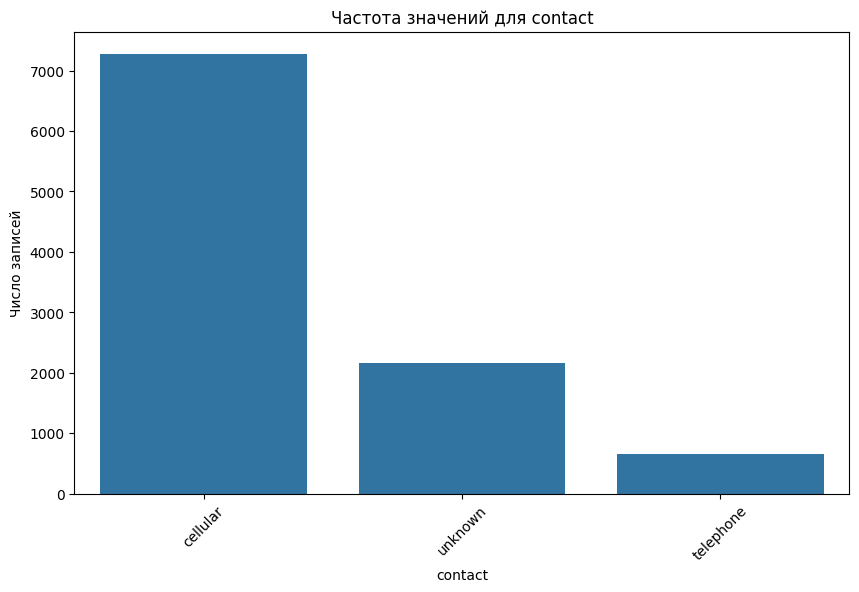

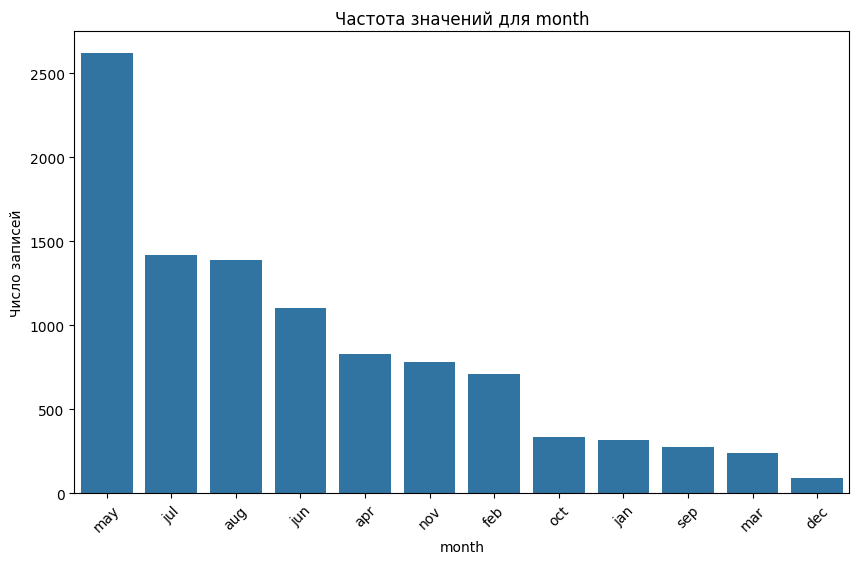

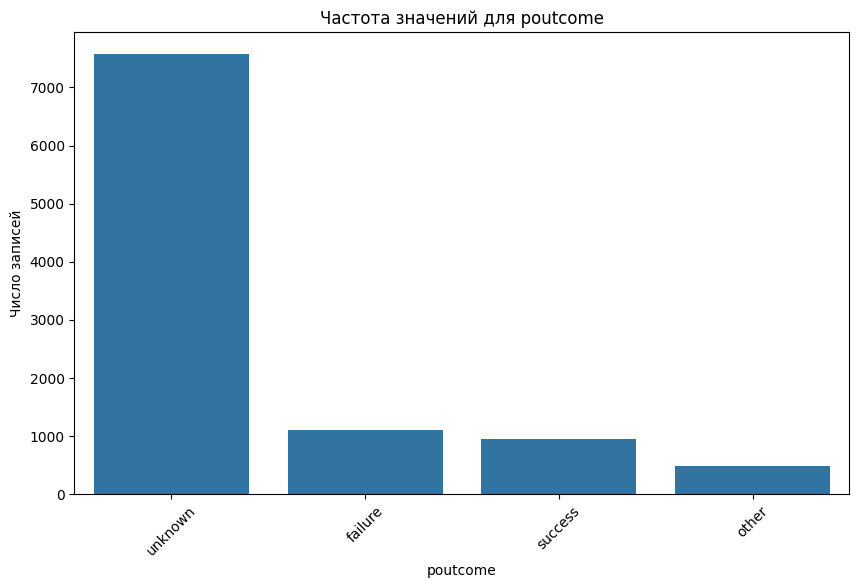

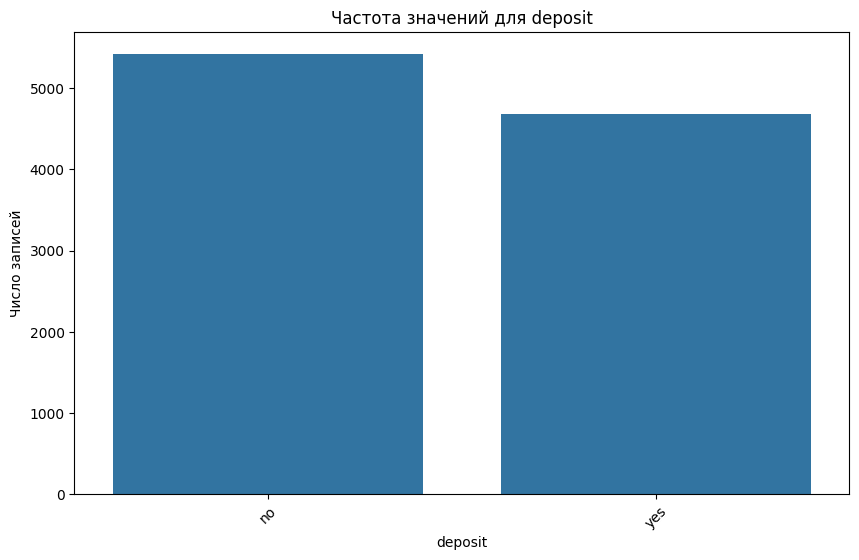

In [665]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
description = cleaned_df.describe(include='object')
display(description)


#постройте визуализации, иллюстрирующие результаты

types = cleaned_df.dtypes
cat_features = list(types[(types == 'object')].index)
cat_features


# Функция для построения столбчатой диаграммы
def plot_category_counts(dataframe, category):
    plt.figure(figsize=(10, 6))
    sns.countplot(data=dataframe, x=category, order=dataframe[category].value_counts().index)
    plt.title(f'Частота значений для {category}')
    plt.xlabel(category)
    plt.ylabel('Число записей')
    plt.xticks(rotation=45)
    plt.show()

# Перебираем категориальные переменные и строим графики
for feature in cat_features:
    plot_category_counts(cleaned_df, feature)

### Задание 6

deposit     no   yes
poutcome            
failure    562   547
other      216   265
success     84   861
unknown   4562  3008


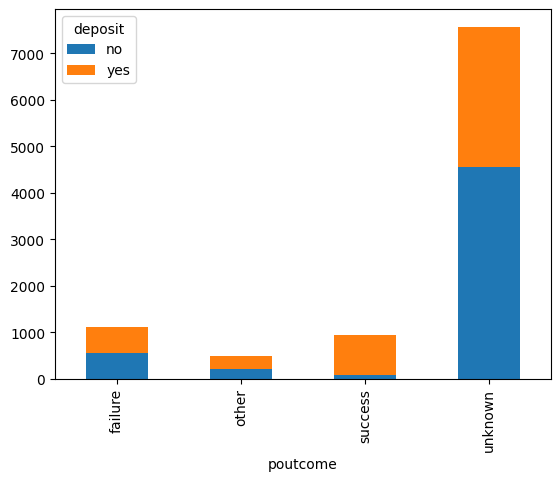

In [666]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# Используем группировку 'deposit' по индексу 'poutcome'

types = cleaned_df.groupby("poutcome")['deposit'].value_counts(normalize=False).unstack()
types.plot(kind='bar', stacked='True')

# Получаем количество успехов и неудач по статусам предыдущей кампании
poutcome_counts = cleaned_df.groupby('poutcome')['deposit'].value_counts().unstack().fillna(0)

# Печатаем результаты
print(poutcome_counts)

### Задание 7

In [667]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
failure_month = cleaned_df[cleaned_df['poutcome'] == 'failure']
display(failure_month.describe(include=object))

# Resolucao 2
# Группируем данные по месяцу
monthly_counts = cleaned_df.groupby('month')['deposit'].value_counts().unstack(fill_value=0)

# Выводим результат
print(monthly_counts)

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,1109,1109,1109,1109,1109,1109,1109,1109,1109,1109
unique,11,3,3,2,2,2,3,12,1,2
top,management,married,secondary,no,yes,no,cellular,may,failure,no
freq,260,645,617,1101,668,948,1035,335,1109,562


deposit    no  yes
month             
apr       317  513
aug       775  610
dec         9   84
feb       323  386
jan       194  125
jul       836  582
jun       606  498
mar        24  213
may      1776  841
nov       456  324
oct        62  273
sep        46  232


### Задание 8

deposit      no   yes
age_group            
<30         594   861
30-40      2245  1716
40-50      1444   938
50-60       984   670
60+         157   496


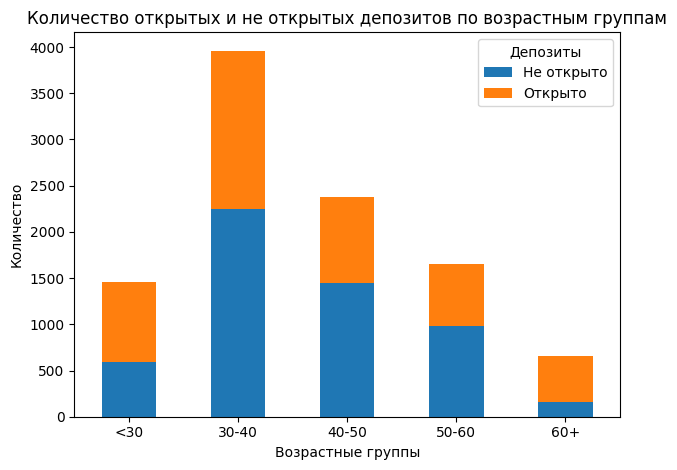

In [668]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
# Определяем категории возрастов
bins = [-1, 29, 39, 49, 59, 100]
labels = ['<30', '30-40', '40-50', '50-60', '60+']

# Создаем новую переменную с категориями
cleaned_df['age_group'] = pd.cut(cleaned_df['age'], bins=bins, labels=labels)

# Просмотр результата
#display(df)

# Группируем по возрастной категории и подсчитываем открытые и не открытые
age_deposit_counts = cleaned_df.groupby('age_group')['deposit'].value_counts().unstack(fill_value=0)
print(age_deposit_counts)

# Построение диаграммы
age_deposit_counts.plot(kind='bar', stacked=True)

# Настройки графика
plt.title('Количество открытых и не открытых депозитов по возрастным группам')
plt.xlabel('Возрастные группы')
plt.ylabel('Количество')
plt.xticks(rotation=0)
plt.legend(['Не открыто', 'Открыто'], title='Депозиты')
plt.tight_layout()
plt.show()

### Задания 9 и 10

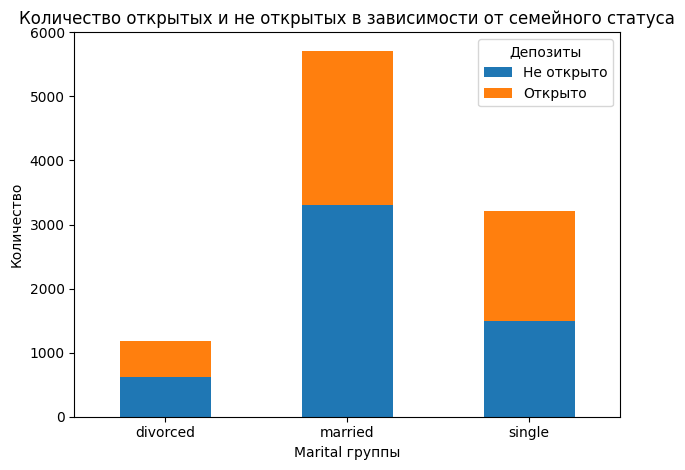

In [669]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
marital_deposit_counts = cleaned_df.groupby('marital')['deposit'].value_counts().unstack(fill_value=0)

# Построение диаграммы
marital_deposit_counts.plot(kind='bar', stacked=True)

# Настройки графика
plt.title('Количество открытых и не открытых в зависимости от семейного статуса')
plt.xlabel('Marital группы')
plt.ylabel('Количество')
plt.xticks(rotation=0)
plt.legend(['Не открыто', 'Открыто'], title='Депозиты')
plt.tight_layout()
plt.show()

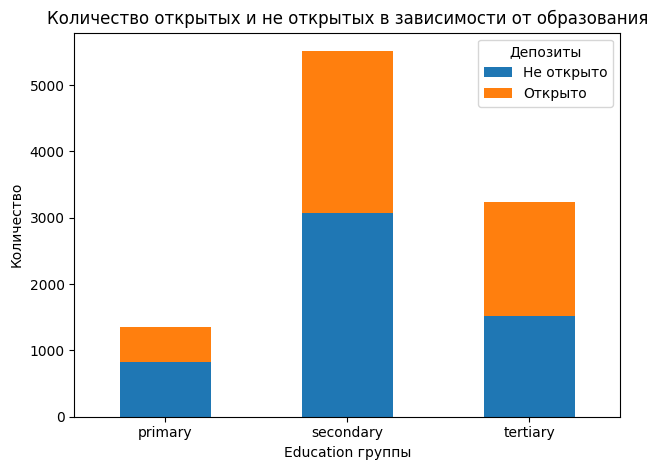

In [670]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
education_deposit_counts = cleaned_df.groupby('education')['deposit'].value_counts().unstack(fill_value=0)

# Построение диаграммы
education_deposit_counts.plot(kind='bar', stacked=True)

# Настройки графика
plt.title('Количество открытых и не открытых в зависимости от образования')
plt.xlabel('Education группы')
plt.ylabel('Количество')
plt.xticks(rotation=0)
plt.legend(['Не открыто', 'Открыто'], title='Депозиты')
plt.tight_layout()
plt.show()

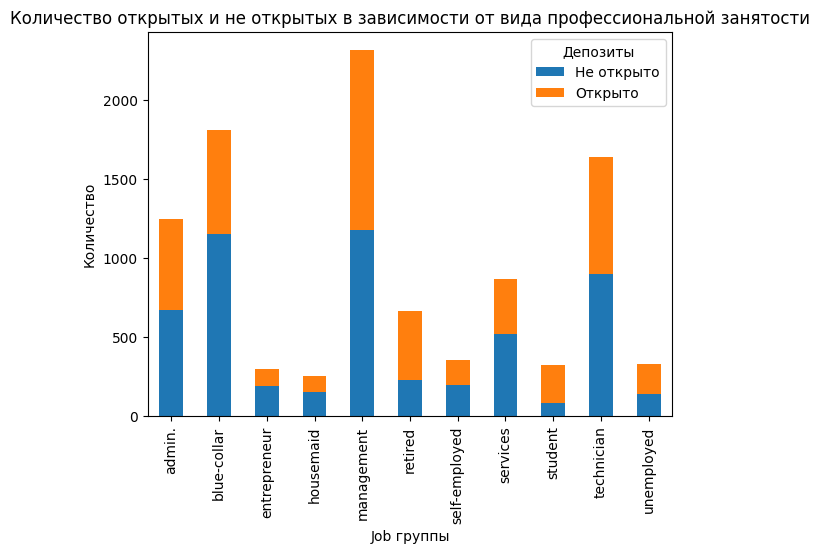

management


In [671]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
job_deposit_counts = cleaned_df.groupby('job')['deposit'].value_counts().unstack(fill_value=0)

# Построение диаграммы
job_deposit_counts.plot(kind='bar', stacked=True)

# Настройки графика
plt.title('Количество открытых и не открытых в зависимости от вида профессиональной занятости')
plt.xlabel('Job группы')
plt.ylabel('Количество')
plt.xticks(rotation=0)
plt.legend(['Не открыто', 'Открыто'], title='Депозиты')
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

# Для определения группы клиентов с наибольшим числом, можно использовать следующую группировку:

most_common_job = cleaned_df['job'].value_counts().idxmax()
print(most_common_job)

### Задание 11

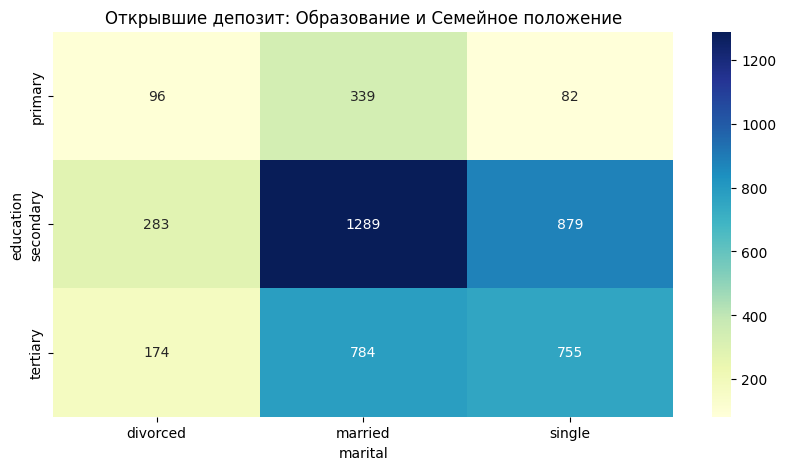

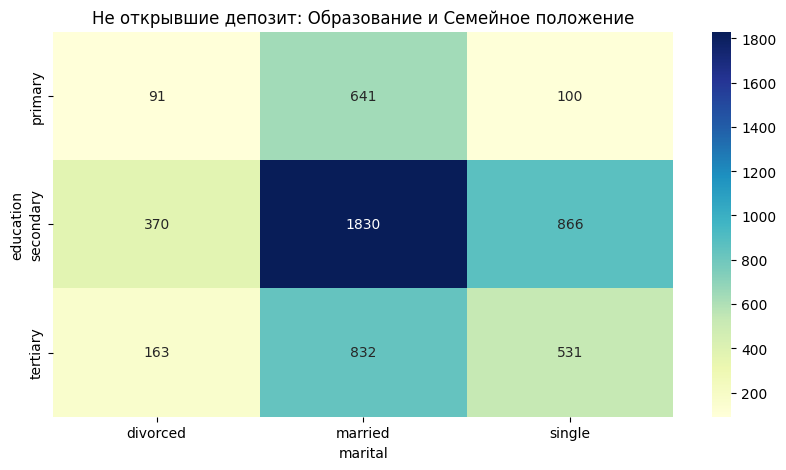

In [672]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)

# Сначала создадим два отдельных DataFrame: один для тех, кто открыл депозит, и другой для тех, кто не открыл.
opened_deposit = cleaned_df[cleaned_df['deposit'] == 'yes']
not_opened_deposit = cleaned_df[cleaned_df['deposit'] == 'no']

# Затем для каждой из этих таблиц создаем сводную таблицу по уровням образования и семейному положению. Предположим, что у нас есть столбцы education и marital_status.

pivot_opened = pd.pivot_table(opened_deposit, index='education', columns='marital', aggfunc='size', fill_value=0)
pivot_not_opened = pd.pivot_table(not_opened_deposit, index='education', columns='marital', aggfunc='size', fill_value=0)



# Тепловая карта для открывших депозит
plt.figure(figsize=(10, 5))
sns.heatmap(pivot_opened, annot=True, cmap='YlGnBu', fmt='g')
plt.title('Открывшие депозит: Образование и Семейное положение')
plt.show()

# Тепловая карта для не открывших депозит
plt.figure(figsize=(10, 5))
sns.heatmap(pivot_not_opened, annot=True, cmap='YlGnBu', fmt='g')
plt.title('Не открывшие депозит: Образование и Семейное положение')
plt.show()

### Выводы
**Семейное положение:**

Из первой диаграммы, демонстрирующей людей, не открывших депозит, видно, что больше всего отказов наблюдается среди женатых/замужних клиентов (1830). Та же тенденция прослеживается и среди открывших депозит: женатых/замужних (1289) здесь также больше. Это может говорить о статусе и финансовой безопасности данных клиентов, которые предпочитают избегать рисков.

**Уровень образования:**

Во всех категориях образования, как видно из обеих диаграмм, больше всего людей с данным уровнем образования (secondary) — это 1830 и 1289 соответственно. Это может свидетельствовать о том, что люди со средним уровнем образования, будучи самыми многочисленными, соответствующим образом распределяются между теми, кто открывает и не открывает депозит.

**Сравнение обученной группы:**

Явно следует заметить, что среди клиентов с высшим образованием (tertiary) больше людей, которые готовы открывать депозит (755 и 784 против 163 и 174 неоткрывших), что свидетельствует о большей финансовой грамотности и уверенности в финансах среди этой группы населения.

### Общие выводы

1. Поддержка семей: Рекомендуется разработать продукты и предложения, ориентированные на семейных клиентов, для повышения их интереса к депозитным продуктам.

2. Образовательные кампании: Акцент на финансовую грамотность может положительно повлиять на клиентов с более низким уровнем образования, мотивируя их к открытию депозитов.

3. Привлечение клиентов с высшим образованием: Разработка специальных предложений для обладателей высшего образования с целью повышения их интереса к различным финансовым услугам.

## Часть 3: преобразование данных

### Задание 1

In [673]:
# преобразуйте уровни образования

LE = LabelEncoder()
cleaned_df['education'] = LE.fit_transform(cleaned_df['education'])

# Находим сумму преобразованных значений
sum_education = cleaned_df['education'].sum()
print(sum_education)

# Создаем объект LabelEncoder
LE_age = LabelEncoder()

# Преобразуем порядковую переменную возраста
cleaned_df['age_group'] = LE_age.fit_transform(cleaned_df['age_group'])

# Проверяем результат
display(cleaned_df.head(5))

11995


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_group
0,59,admin.,married,1,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes,2
1,56,admin.,married,1,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes,2
2,41,technician,married,1,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes,1
3,55,services,married,1,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes,2
4,54,admin.,married,2,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes,2


### Задания 2 и 3

In [674]:
# преобразуйте бинарные переменные в представление из нулей и единиц
cleaned_df['loan'] = cleaned_df['loan'].apply(lambda x: 1 if x == 'yes' else 0)
cleaned_df['housing'] = cleaned_df['housing'].apply(lambda x: 1 if x == 'yes' else 0)
cleaned_df['deposit'] = cleaned_df['deposit'].apply(lambda x: 1 if x == 'yes' else 0)
cleaned_df['default'] = cleaned_df['default'].apply(lambda x: 1 if x == 'yes' else 0)

cleaned_df.head(4)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_group
0,59,admin.,married,1,0,2343.0,1,0,unknown,5,may,1042,1,-1,0,unknown,1,2
1,56,admin.,married,1,0,45.0,0,0,unknown,5,may,1467,1,-1,0,unknown,1,2
2,41,technician,married,1,0,1270.0,1,0,unknown,5,may,1389,1,-1,0,unknown,1,1
3,55,services,married,1,0,2476.0,1,0,unknown,5,may,579,1,-1,0,unknown,1,2


In [675]:
print(cleaned_df['deposit'].value_counts())

std_deposit = cleaned_df['deposit'].std()
print(round(std_deposit, 3))

deposit
0    5424
1    4681
Name: count, dtype: int64
0.499


In [676]:
# Вычисляем средние арифметические
mean_loan = cleaned_df['loan'].mean()
mean_housing = cleaned_df['housing'].mean()
mean_default = cleaned_df['default'].mean()

# Суммируем средние значения
total_mean = mean_loan + mean_housing + mean_default


# Округляем итог до трёх знаков
result = round(total_mean, 3)

# Вывод результата
print(result)

0.635


### Задание 4

In [677]:
# создайте дамми-переменные
# Посмотрим на число уникальных значений номинальных признаков

columns_to_change = ['job', 'marital', 'contact', 'month', 'poutcome']
 
for column in columns_to_change:
 print('Число уникальных значений призкака {}: '.format(column), cleaned_df[column].nunique())

Число уникальных значений призкака job:  11
Число уникальных значений призкака marital:  3
Число уникальных значений призкака contact:  3
Число уникальных значений призкака month:  12
Число уникальных значений призкака poutcome:  4


In [678]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder()
 
# 'учим' и сразу применяем преобразование к выборке, результат переводим в массив
data_onehot = one_hot_encoder.fit_transform(cleaned_df[columns_to_change]).toarray() 

# запишем полученные названия новых колонок в отдельную переменную
column_names = one_hot_encoder.get_feature_names_out(columns_to_change)
print(column_names)

# Преобразуйте полученный массив закодированных данных в формат DataFrame, явно указав имена колонок.
data_onehot = pd.DataFrame(data_onehot, index=cleaned_df.index, columns=column_names)

# Для того чтобы соединить таблицы по столбцам, необходимо явно указать axis = 1.
data_new = pd.concat([cleaned_df, data_onehot], axis=1)

# Удалите закодированные столбцы columns_to_change из полученной таблицы.
data_new = data_new.drop(columns=columns_to_change)

# Проверка формы DataFrame
data_new.shape

['job_admin.' 'job_blue-collar' 'job_entrepreneur' 'job_housemaid'
 'job_management' 'job_retired' 'job_self-employed' 'job_services'
 'job_student' 'job_technician' 'job_unemployed' 'marital_divorced'
 'marital_married' 'marital_single' 'contact_cellular' 'contact_telephone'
 'contact_unknown' 'month_apr' 'month_aug' 'month_dec' 'month_feb'
 'month_jan' 'month_jul' 'month_jun' 'month_mar' 'month_may' 'month_nov'
 'month_oct' 'month_sep' 'poutcome_failure' 'poutcome_other'
 'poutcome_success' 'poutcome_unknown']


(10105, 46)

In [679]:
data_new.head()

,age,education,default,balance,housing,loan,day,duration,campaign,pdays,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,59,1,0,2343.0,1,0,5,1042,1,-1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,56,1,0,45.0,0,0,5,1467,1,-1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,41,1,0,1270.0,1,0,5,1389,1,-1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,55,1,0,2476.0,1,0,5,579,1,-1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,54,2,0,184.0,0,0,5,673,2,-1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [680]:
 #  Создание dummy-переменных:
#dt_dummies = pd.get_dummies(cleaned_df[['job', 'marital', 'contact', 'month', 'poutcome']], drop_first=True)

# Объединение с исходным DataFrame
#cleaned_df = pd.concat([cleaned_df, dt_dummies], axis=1)

# Проверка формы DataFrame
#cleaned_df.shape

# apaguei aqui essas colunas porque ,por algum motivo nao detetado elas nao foram apagadas no momento da categorizacao
#cleaned_df = cleaned_df.drop(columns=['job', 'marital', 'contact', 'month', 'poutcome'])

#print("Current columns: ", cleaned_df.columns)

# Перевод из boolean в 0/1
# Если у вас уже есть столбцы типа bool, и вы хотите просто заменить значения True/False на 1/0, ваш код уже правильно выполняет это преобразование:

#boolean_columns = cleaned_df.select_dtypes(include=['bool']).columns
#cleaned_df[boolean_columns] = cleaned_df[boolean_columns].astype(int)

#display(cleaned_df.head(5))

### Задания 5 и 6

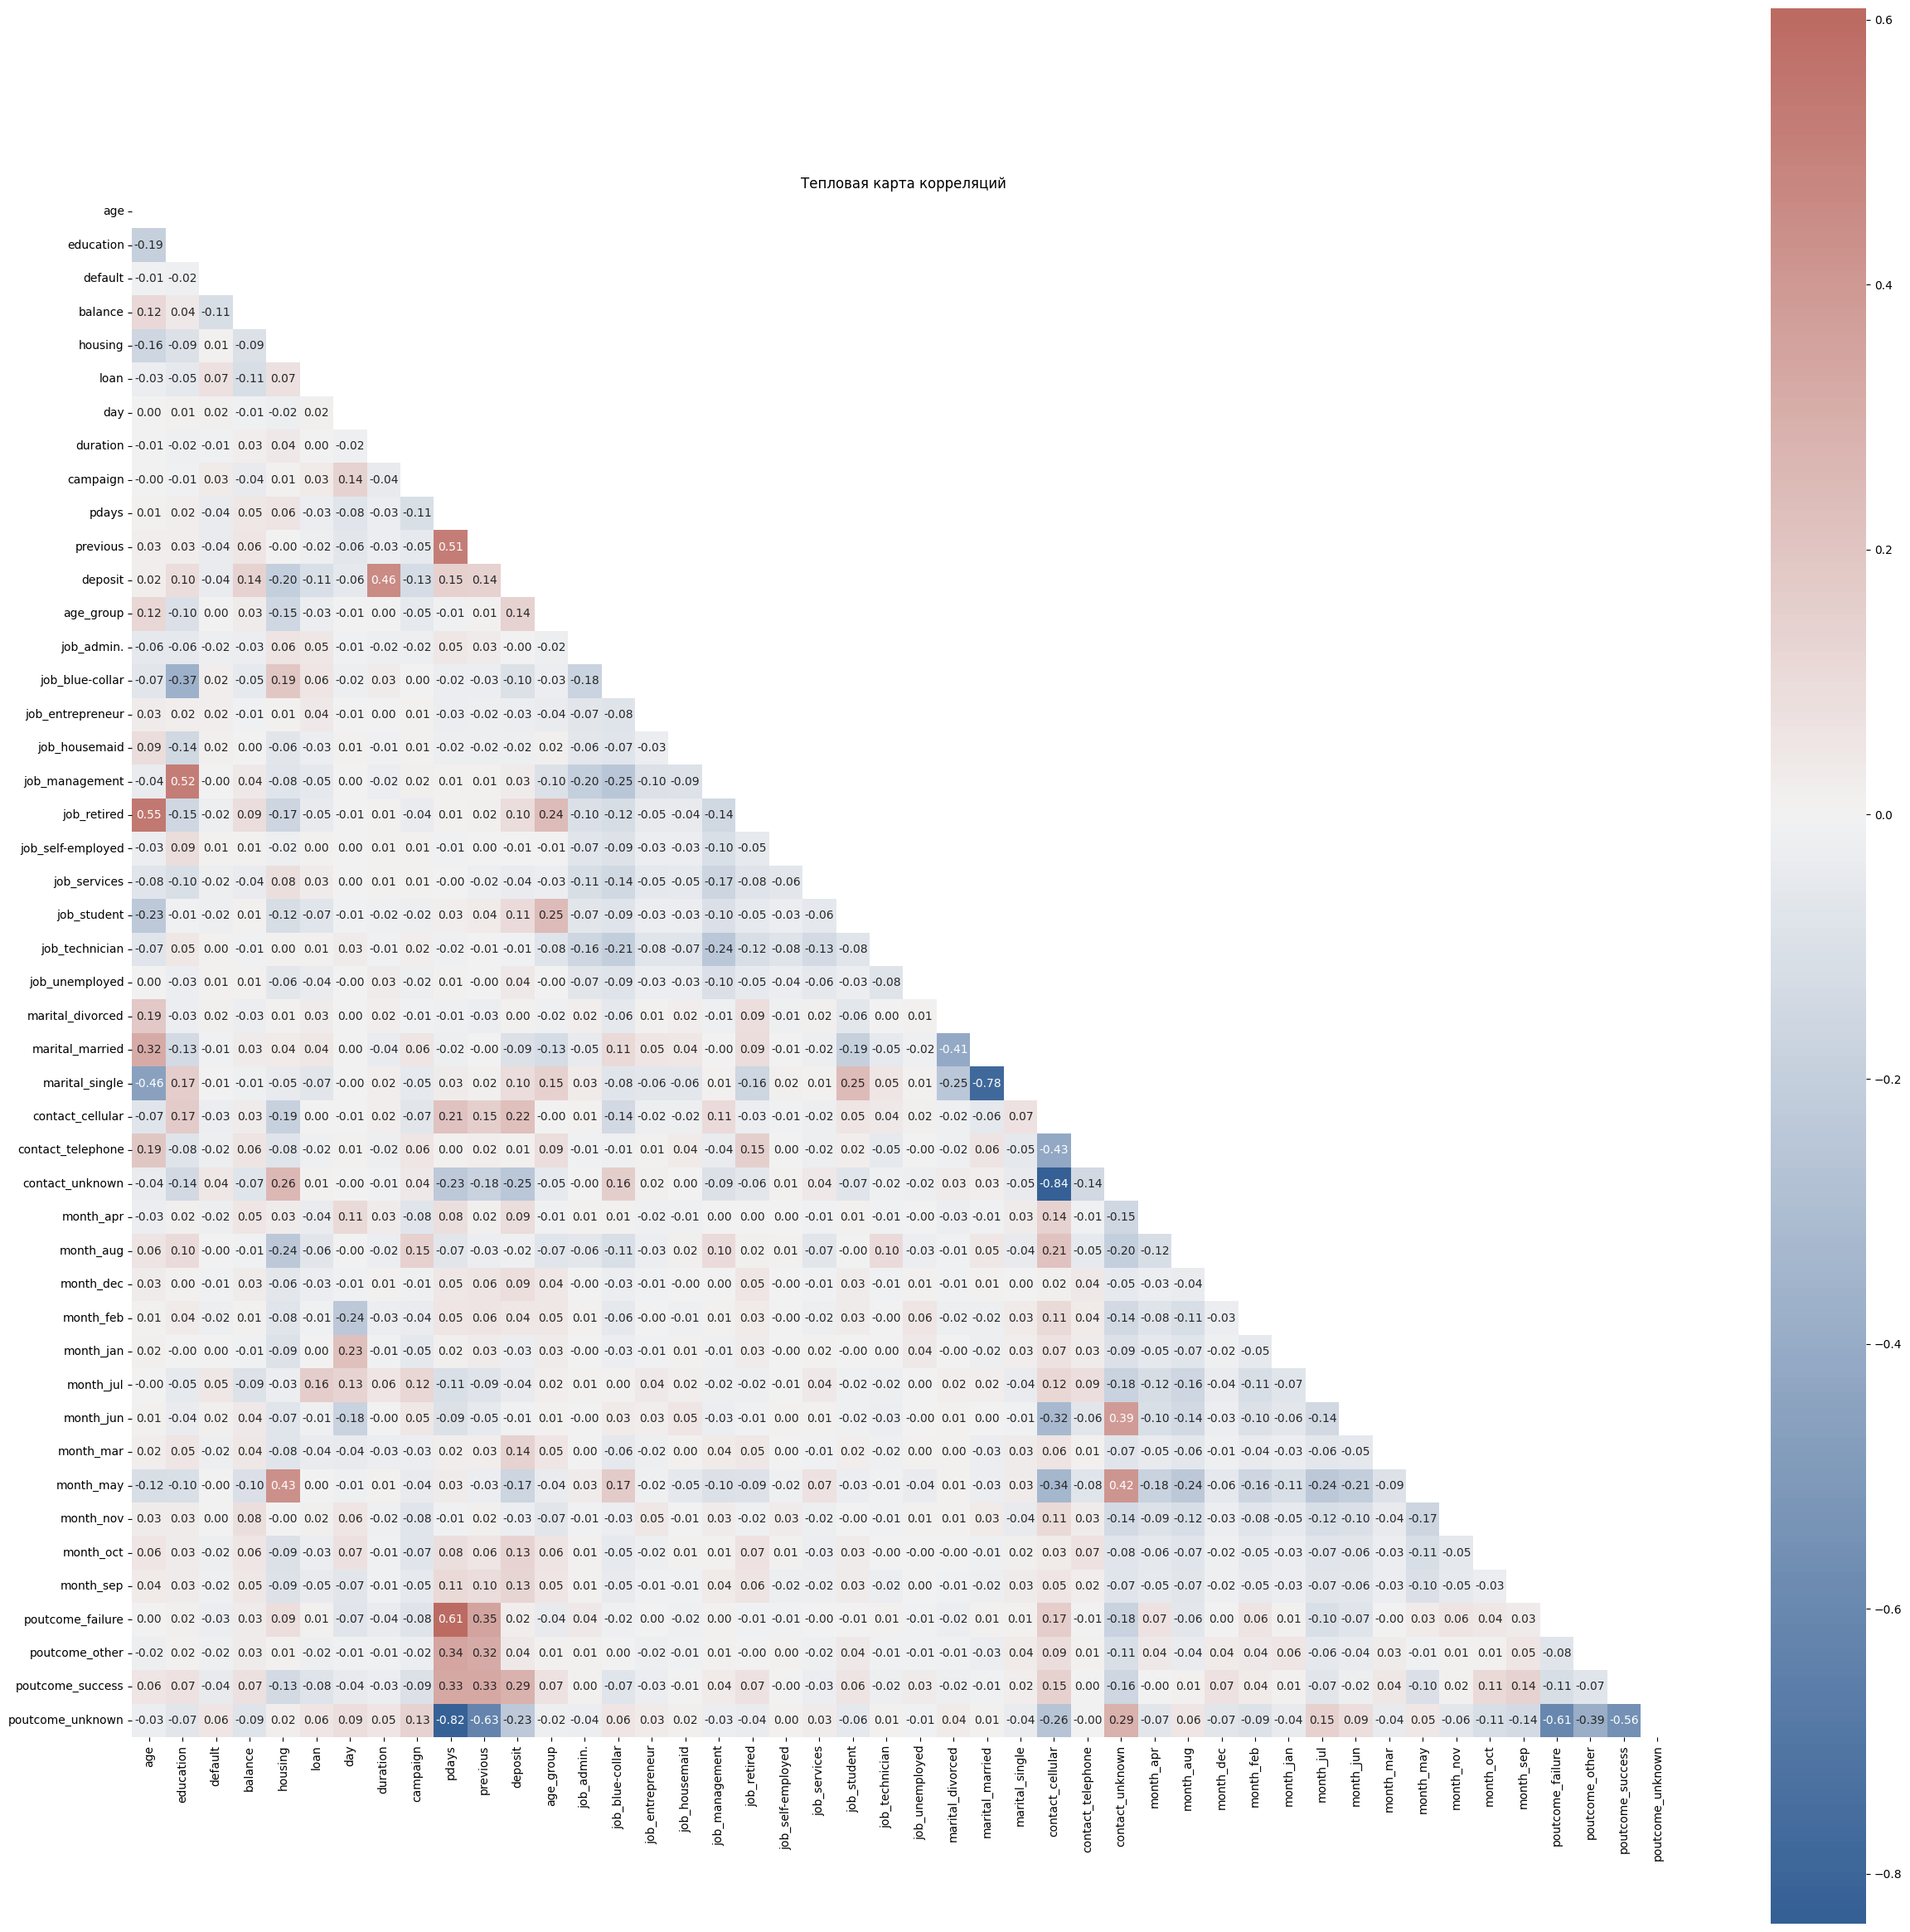

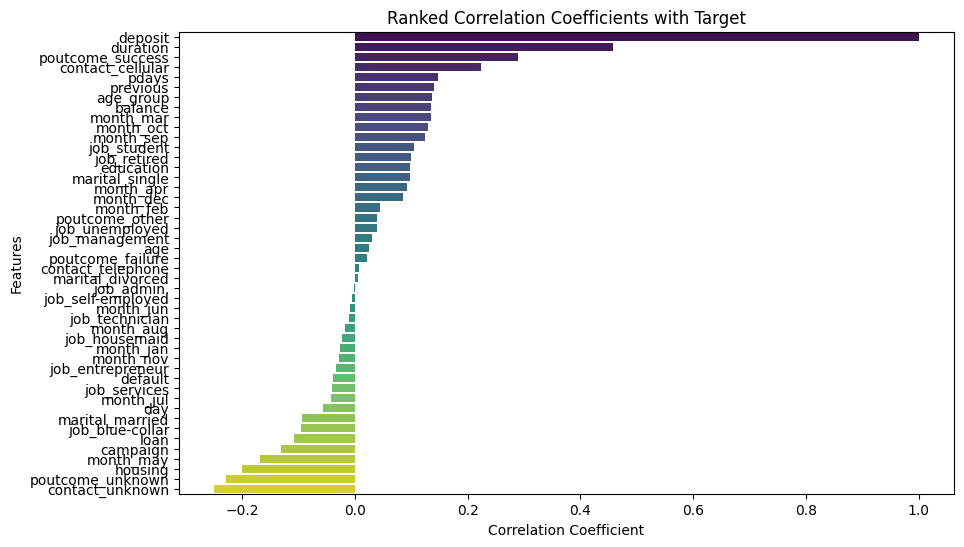

In [681]:
correlation_matrix = data_new.corr()

cmap = sns.diverging_palette(250, 15, s=75, l=40,
                             n=9, center="light", as_cmap=True)

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
# Построение тепловой карты
fig = plt.figure(figsize=(30, 30))
sns.heatmap(correlation_matrix, mask=mask, fmt='.2f', center=0,
            annot=True, square=True, cmap=cmap),
plt.title('Тепловая карта корреляций')  # Добавляем заголовок
plt.show()

# Извлечение корреляции с целевой переменной ("deposit")
target_corr = correlation_matrix['deposit'].sort_values(ascending=False)

# Визуализация столбчатой диаграммы
plt.figure(figsize=(10, 6))
sns.barplot(x=target_corr.values, y=target_corr.index, palette='viridis')
plt.title('Ranked Correlation Coefficients with Target')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.show()

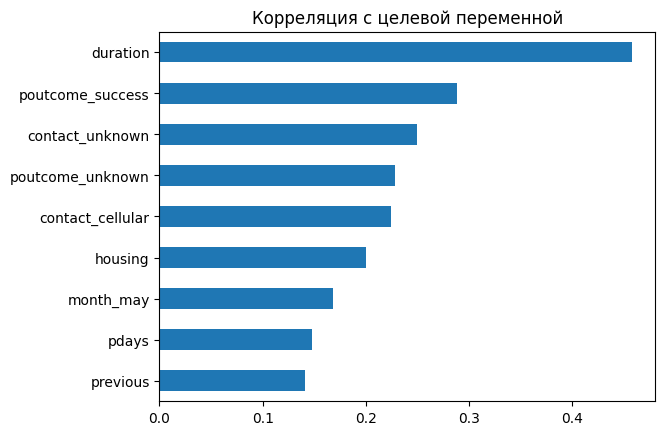

In [682]:
correlation_matrix['deposit'].apply(lambda x: abs(x)).sort_values()[-10:-1].plot.barh()
plt.title('Корреляция с целевой переменной')
plt.show()

In [683]:
correlation_matrix['deposit']

age                  0.024357
education            0.098253
default             -0.038872
balance              0.135893
housing             -0.200290
loan                -0.107240
day                 -0.056878
duration             0.457818
campaign            -0.130707
pdays                0.147917
previous             0.141102
deposit              1.000000
age_group            0.136243
job_admin.          -0.001927
job_blue-collar     -0.095845
job_entrepreneur    -0.032706
job_housemaid       -0.022572
job_management       0.029566
job_retired          0.100090
job_self-employed   -0.005194
job_services        -0.040433
job_student          0.105563
job_technician      -0.011190
job_unemployed       0.039196
marital_divorced     0.004808
marital_married     -0.094246
marital_single       0.097005
contact_cellular     0.223944
contact_telephone    0.007064
contact_unknown     -0.249294
month_apr            0.092888
month_aug           -0.018225
month_dec            0.085041
month_feb 

### Интерпретация ранговой корреляции с целевой переменной

1. Наиболее значимые признаки:
    - Duration (0.56): Наиболее высокая корреляция с целевой переменной (deposit). Это значит, что время последнего разговора клиента (длительность звонка) имеет прямую связь с вероятностью открытия депозита. Данный признак очень важен и, вероятно, должен быть включен в модели.
    - Pdays (0.23): Количество дней с последнего контакта также положительно связано с целевой переменной, но уровень связи менее выражен.
    - Previous (0.15): Число предыдущих контактов с клиентом также имеет положительную связь с целевой переменной.
    - Age_group (0.14) и Balance (0.11): Возрастная группа клиента и его баланс на счете также показывают положительную, хотя и слабую взаимосвязь.

2. Менее значимые и отрицательные признаки:
    - Campaign (-0.10) и Housing (-0.17): Количество маркетинговых кампаний и наличие у клиента ипотечного кредита отрицательно коррелируют с целевой переменной. Например, клиенты с ипотекой менее склонны открывать депозит.
    - Loan (-0.11): Клиенты с открытым кредитом на потребительские нужды также чаще отказываются от депозитов.

3. Факторы с незначительным влиянием:
    - Некоторые признаки (например, Day и Default) имеют близкую к нулю корреляцию с целевой переменной, что указывает на их низкую значимость в рамках этой задачи.

---

### Интерпретация тепловой карты корреляций между признаками

1. Высокая внутренняя корреляция:
    - Pdays и Previous имеют значительную корреляцию (0.51). Это ожидаемо, так как оба признака связаны с предыдущей маркетинговой активностью.
    - Duration и Deposit: Как отмечено ранее, высокая взаимосвязь (0.56) подтверждается на тепловой карте.

2. Отсутствие мультиколлинеарности:
    - Большинство признаков имеют низкие или умеренные корреляции между собой. Это положительно сказывается на построении модели, так как минимизируется риск мультиколлинеарности, за исключением некоторых связанных пар, таких как Pdays и Previous.

3. Полезные связи для анализа:
    - Age_group, Duration и Balance явно имеют связи с целевой переменной, но их низкая корреляция между собой говорит о том, что они могут независимо влиять на целевую функцию.

---

### Выводы

- Основной признак "Duration" играет ключевую роль в прогнозировании депозита. Однако, следует учитывать, что это признак, который может быть известен только после контакта с клиентом (запоздалый признак). Поэтому его использование в практике предсказания требует внимательного анализа.
  
- Признаки, такие как Pdays, Previous, Balance, Age_group, имеют дополнительные ценные сигналы для анализа, и их стоит использовать в модели прогнозирования.

- Некоторые признаки с низкой корреляцией (Default, Day и др.) могут быть исключены в процессе построения модели, чтобы минимизировать шум.

### Задания 7 и 8

In [684]:
X = data_new.drop(['deposit'], axis=1)
y = data_new['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [685]:
# рассчитайте необходимые показатели
print('X_train', X_train.shape)
print('X_test', X_test.shape)
print('y_train', y_train.shape)
print('y_test', y_test.shape)

X_train (6770, 45)
X_test (3335, 45)
y_train (6770,)
y_test (3335,)


In [686]:
# Каково среднее значение целевой переменной на тестовой выборке? Ответ округлите до двух знаков после точки-разделителя.
mean_value = np.mean(y_test)
rounded_mean_value = round(mean_value, 2)

rounded_mean_value

0.46

### Задание 9

In [687]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
# Инициализируем SelectKBest с метрикой ANOVA F-меры
selector = SelectKBest(score_func=f_classif, k=15)

# Обучение селектора на данных
selector.fit(X_train, y_train)

# Получение имен выбранных признаков
selected_features = selector.get_feature_names_out()

print("Выбранные признаки:", selected_features)

Выбранные признаки: ['balance' 'housing' 'duration' 'campaign' 'pdays' 'previous' 'age_group'
 'contact_cellular' 'contact_unknown' 'month_mar' 'month_may' 'month_oct'
 'month_sep' 'poutcome_success' 'poutcome_unknown']


### Задание 10

In [688]:
# нормализуйте данные с помощью minmaxsxaler

# Создаем экземпляр MinMaxScaler
scaler = MinMaxScaler()

# Фитируем скейлер на обучающих данных и трансформируем их
X_train_scaled = scaler.fit_transform(X_train)

# Применяем тот же скейлер к тестовым данным
X_test_scaled = scaler.transform(X_test)

# Выводим формы преобразованных данных
print('X_train', X_train_scaled.shape)
print('X_test', X_test_scaled.shape)

X_train (6770, 45)
X_test (3335, 45)


In [697]:
# Извлекаем первый предиктор из нормализованной тестовой выборки

# Рассчитайте среднее для признака balance
mean_first_column = X_test_scaled[:, 3].mean()  # Индекс зависит от положения в массиве

# Округляем результат до двух знаков после запятой
mean_first_column_rounded = round(mean_first_column, 2)

print('Среднее арифметическое для признака balance:', mean_first_column_rounded)


Среднее арифметическое для признака balance: 0.47


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [698]:
# обучите логистическую регрессию и рассчитайте метрики качества
# Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(
    solver='sag',  # алгоритм оптимизации
    random_state=42,  # генератор случайных чисел
    max_iter=1000  # количество итераций на сходимость
)

# Обучаем модель, минимизируя logloss
log_reg.fit(X_train_scaled, y_train)

# Делаем предсказание для тренировочной выборки
y_train_pred = log_reg.predict(X_train_scaled)

# Выводим точность на тренировочной выборке
print('Accuracy Train: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))

# Делаем предсказание для тестовой выборки
y_test_pred = log_reg.predict(X_test_scaled)

# Выводим точность на тестовой выборке
print('Accuracy Test: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

# Для подробного отчета о метриках классификации
print("Classification Report Train:")
print(metrics.classification_report(y_train, y_train_pred))

print("Classification Report Test:")
print(metrics.classification_report(y_test, y_test_pred))

Accuracy Train: 0.84
Accuracy Test: 0.82
Classification Report Train:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      3634
           1       0.85      0.80      0.82      3136

    accuracy                           0.84      6770
   macro avg       0.84      0.84      0.84      6770
weighted avg       0.84      0.84      0.84      6770

Classification Report Test:
              precision    recall  f1-score   support

           0       0.81      0.86      0.83      1790
           1       0.82      0.77      0.80      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.81      0.82      3335
weighted avg       0.82      0.82      0.82      3335



### Вывод

Модель логистической регрессии работает хорошо — она обучилась качественно, без явных признаков переобучения или утечки данных. Позволить себе такую разницу в 2% между тренировочной и тестовой точностью вполне приемлемо.

### Задания 2,3,4

In [699]:
# обучите решающие деревья, настройте максимальную глубину

#Создаём объект класса DecisionTreeClassifier
dtc = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    random_state=42 #генератор случайных чисел
)
#Обучаем модель, минимизируя logloss
dtc.fit(X_train_scaled, y_train)

#Делаем предсказание для тренировочной выборки
y_train_pred = dtc.predict(X_train_scaled)

#Вывод отчет о метриках классификации
print('Accuracy Train: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))

#Делаем предсказание для тестовой выборки
y_test_pred = dtc.predict(X_test_scaled)

#Вывод отчет о метриках классификации
print('Accuracy Test: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

Accuracy Train: 1.00
Accuracy Test: 0.78


### Вывод

1. Переобучение:
   Train F1-Score составляет 1.00, что указывает на идеальное соответствие модели тренировочным данным. Однако Test F1-Score значительно ниже — 0.78. Это явный признак переобучения, когда модель запомнила специфические детали тренировочного набора и не может хорошо обобщить для тестового.

2. Решение:
   - Ограничение глубины дерева может помочь в борьбе с переобучением. Попробуйте настроить гиперпараметр max_depth для контролирования максимальной глубины дерева.
   - Подбирайте значения, чтобы уменьшить разрыв между F1-Score тренировочной и тестовой выборок, сохраняя при этом баланс между недообучением и переобучением.

3. Способы улучшения:
   - Используйте кросс-валидацию для подбора оптимального значения max_depth.
   - Примените обрезку дерева (pruning) и другие регуляризационные методы.
   - Если необходимо, попробуйте более сложные модели, такие как случайные леса или бустинг, которые более устойчивы к переобучению.

Используем указанные советы для оптимизации модели решающего дерева и улучшения показателей обобщения.

### Задание 5

In [701]:
# подберите оптимальные параметры с помощью gridsearch

param_grid = {'min_samples_leaf': list(np.linspace(5, 100, 50, dtype=int)),
              'max_depth': list(np.linspace(1, 30, 50, dtype=int)),
              'criterion':['entropy','gini']
              }
            
grid_search_tree = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)
%time grid_search_tree.fit(X_train_scaled, y_train) 

#Делаем предсказание для тренировочной выборки
y_train_pred = grid_search_tree.predict(X_train_scaled)

#Вывод отчет о метриках классификации
print('Accuracy Train: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))

#Делаем предсказание для тестовой выборки
y_test_pred = grid_search_tree.predict(X_test_scaled)

#Вывод отчет о метриках классификации
print('Accuracy Test: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))


print("Наилучшие значения гиперпараметров: {}".format(grid_search_tree.best_params_))

CPU times: total: 9.02 s
Wall time: 4min 15s
Accuracy Train: 0.87
Accuracy Test: 0.81
Наилучшие значения гиперпараметров: {'criterion': 'entropy', 'max_depth': 14, 'min_samples_leaf': 18}


In [702]:
param_grid = {'min_samples_leaf': list(np.linspace(2, 5, 7, 10, dtype=int)),
              'max_depth': list(np.linspace(3,5,7, dtype=int)),
              'criterion':['entropy','gini']
              }
            
grid_search_tree = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)
%time grid_search_tree.fit(X_train_scaled, y_train) 
#Делаем предсказание для тренировочной выборки
y_train_pred = grid_search_tree.predict(X_train_scaled)

#Вывод отчет о метриках классификации
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))

#Делаем предсказание для тестовой выборки
y_test_pred = grid_search_tree.predict(X_test_scaled)

#Вывод отчет о метриках классификации
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))


print("Наилучшие значения гиперпараметров: {}".format(grid_search_tree.best_params_))

CPU times: total: 406 ms
Wall time: 3.51 s
f1_score на обучающем наборе: 0.81
f1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 3}


In [706]:
param_grid = {'min_samples_leaf': list(np.linspace(2, 5, 7, 10, dtype=int)),
              'max_depth': list(np.linspace(3,5,7, dtype=int)),
              'criterion':['gini']
              }
            
grid_search_tree = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)
%time grid_search_tree.fit(X_train_scaled, y_train) 
#Делаем предсказание для тренировочной выборки
y_train_pred = grid_search_tree.predict(X_train_scaled)

#Вывод отчет о метриках классификации
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))

#Делаем предсказание для тестовой выборки
y_test_pred = grid_search_tree.predict(X_test_scaled)

#Вывод отчет о метриках классификации
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))


print("Наилучшие значения гиперпараметров: {}".format(grid_search_tree.best_params_))

CPU times: total: 234 ms
Wall time: 4.21 s
f1_score на обучающем наборе: 0.81
f1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 3}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [707]:
# обучите на ваших данных случайный лес
# Создаем объект класса RandomForestClassifier
rf = ensemble.RandomForestClassifier(
    n_estimators=100,        # количество деревьев
    criterion='gini',     # критерий информативности
    max_depth=10,             # максимальная глубина каждого дерева
    min_samples_leaf=5,     # минимальное число объектов в листе
   # max_features='sqrt',     # количество признаков, рассматриваемых при каждом разбиении
    random_state=42          # генератор случайных чисел для воспроизводимости
)

# Обучаем модель на тренировочных данных
rf.fit(X_train_scaled, y_train)

#Выводим значения метрики 
y_train_pred = rf.predict(X_train_scaled)
print('Accuracy на обучающем наборе: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('Recall на обучающем наборе: {:.2f}'.format(metrics.recall_score(y_train, y_train_pred)))

y_test_pred = rf.predict(X_test_scaled)
print('Accuracy на тестовом наборе: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print('Recall на тестовом наборе: {:.2f}'.format(metrics.recall_score(y_test, y_test_pred)))

Accuracy на обучающем наборе: 0.88
Recall на обучающем наборе: 0.89
Accuracy на тестовом наборе: 0.84
Recall на тестовом наборе: 0.85


### Задания 2 и 3

In [709]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
gb = GradientBoostingClassifier(
    # loss='log_loss', #функция потерь
    learning_rate=0.05, #темп обучения
    n_estimators=300, #число деревьев
    max_depth=5, #максимальная глубина дерева
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел
)

#Обучаем модель
gb.fit(X_train_scaled, y_train)

#Делаем предсказание для тренировочной выборки
y_train_pred = gb.predict(X_train_scaled)

#Вывод отчет о метриках классификации
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))

#Делаем предсказание для тестовой выборки
y_test_pred = gb.predict(X_test_scaled)

#Вывод отчет о метриках классификации
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))


f1_score на обучающем наборе: 0.91
f1_score на тестовом наборе: 0.85


In [710]:
# Прогнозируем вероятности принадлежности к классам

y_pred_proba = gb.predict_proba(X_test)
print(y_pred_proba)

[[0.34807625 0.65192375]
 [0.04220773 0.95779227]
 [0.07854599 0.92145401]
 ...
 [0.12950092 0.87049908]
 [0.06207571 0.93792429]
 [0.10539769 0.89460231]]


### Задание 4

In [712]:
# объедините уже известные вам алгоритмы с помощью стекинга 
# Создаем список кортежей вида: (наименование модели, модель)
estimators = [
    ('dt', tree.DecisionTreeClassifier(
        criterion='entropy',
        min_samples_leaf=5,
        max_depth=6,
        random_state=42
        )
    ),
    ('log_reg', linear_model.LogisticRegression(
        solver='sag',
        random_state=42 
        )
    ),
    ('gb', ensemble.GradientBoostingClassifier(
        learning_rate=0.05,
        n_estimators=300,
        min_samples_leaf=5,
        max_depth=5,
        random_state=42
        )
    )
]

stack = ensemble.StackingClassifier(
    estimators,
    final_estimator=linear_model.LogisticRegression(random_state=42)
)
stack.fit(X_train_scaled, y_train)

#Делаем предсказание для тренировочной выборки
y_train_pred = stack.predict(X_train_scaled)

#Вывод отчет о метриках классификации
print('precision  на обучающем наборе: {:.2f}'.format(metrics.precision_score(y_train, y_train_pred)))

#Делаем предсказание для тестовой выборки
y_test_pred = stack.predict(X_test_scaled)

#Вывод отчет о метриках классификации
print('precision на тестовом наборе: {:.2f}'.format(metrics.precision_score(y_test, y_test_pred)))

precision  на обучающем наборе: 0.89
precision на тестовом наборе: 0.83


### Задание 5

In [713]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

# с помощью SelectKBest отберите 3 наиболее подходящих признаков

# Инициализируем SelectKBest с метрикой ANOVA F-меры
selector = SelectKBest(score_func=f_classif, k=3)

# Обучение селектора на данных
selector.fit(X_train, y_train)

# Получение имен выбранных признаков
selected_features = selector.get_feature_names_out()

print("Выбранные признаки:", selected_features)

Выбранные признаки: ['duration' 'contact_unknown' 'poutcome_success']


### Почему именно эти три признака имеют наибольшую важность?

'duration', 'contact_unknown' и 'poutcome_success стали наиболее важными признаками, потому что они наилучшим образом объясняют различия в целевой переменной (например, успешность маркетинговой кампании). Рассмотрим каждый из них подробнее:

1. 'duration' (Длительность):
   - Описание: Этот признак, вероятнее всего, показывает, сколько времени занял последний контакт с клиентом.
   - Значимость: Длительность взаимодействия может быть критическим фактором, так как более длительные взаимодействия могут привести к более детальному обсуждению предложений, увеличивая вероятность положительного результата. Например, в телемаркетинге более длительные звонки, как правило, указывают на заинтересованность клиентов.

2. 'contactunknown' (Неизвестный тип контакта):**
   - *Описание*: Этот признак может обозначать, что информация о типе последнего контакта (например, телефон или электронная почта) недоступна.
   - *Значимость*: Неизвестный тип контакта может быть значим, так как он может отражать недостатки в данных или разные способы ведения кампаний в зависимости от неизвестного типа связи. Это может иметь последствия для стратегии кампании и предоставить информацию для улучшения собираемых данных.

3. **'poutcomesuccess' (Успех предыдущей кампании):
   - Описание: Этот признак указывает на успешность предыдущих маркетинговых попыток.
   - Значимость: Этот признак является важным показателем, так как успешный предыдущий контакт с клиентом увеличивает вероятность успешного завершения текущего взаимодействия. История успешного взаимодействия указывает на лояльность клиента и положительное отношение к предлагавшимся продуктам или услугам.

---

Эти три признака подчеркивают важность как качественных (успех предыдущих кампаний), так и количественных аспектов (длительность контакта) в определении успеха маркетинговой кампании. 
Включение этих признаков в анализ и дальнейшее внимание к ним при планировании и реализации кампаний помогут повысить их эффективность и точность.

### Задания 6,7,8

In [717]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna

def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))

  return score


In [718]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2025-01-27 15:20:20,309] A new study created in memory with name: RandomForestClassifier
[I 2025-01-27 15:20:22,035] Trial 0 finished with value: 0.8819722650231124 and parameters: {'n_estimators': 176, 'max_depth': 16, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.8819722650231124.
[I 2025-01-27 15:20:23,922] Trial 1 finished with value: 0.9022765990398017 and parameters: {'n_estimators': 196, 'max_depth': 29, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.9022765990398017.
[I 2025-01-27 15:20:25,835] Trial 2 finished with value: 0.9232923603547534 and parameters: {'n_estimators': 191, 'max_depth': 19, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.9232923603547534.
[I 2025-01-27 15:20:27,685] Trial 3 finished with value: 0.9546666666666667 and parameters: {'n_estimators': 154, 'max_depth': 22, 'min_samples_leaf': 2}. Best is trial 3 with value: 0.9546666666666667.
[I 2025-01-27 15:20:29,777] Trial 4 finished with value: 0.8951675158252277 and parameters: {'n_

CPU times: total: 27.1 s
Wall time: 30.7 s


In [719]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 122, 'max_depth': 27, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.96


In [721]:
# Оптимальные гиперпараметры
best_params = study.best_params

# Создаем модель с оптимальными гиперпараметрами
optimized_model = ensemble.RandomForestClassifier(n_estimators=best_params['n_estimators'],
                                                  max_depth=best_params['max_depth'],
                                                  min_samples_leaf=best_params['min_samples_leaf'],
                                                  random_state=42)

# Обучаем модель на тренировочной выборке
optimized_model.fit(X_train_scaled, y_train)

# Рассчитываем метрики на тестовой выборке
y_pred = optimized_model.predict(X_test_scaled)

f1 = metrics.f1_score(y_test, y_pred)
accuracy = metrics.accuracy_score(y_test, y_pred)

# Вывод результатов
print(f"F1 на тестовой выборке: {f1:.2f}")
print(f"Accuracy на тестовой выборке: {accuracy:.2f}")

F1 на тестовой выборке: 0.85
Accuracy на тестовой выборке: 0.85


Улучшился ли результат по сравнению с предыдущими моделями

Рассмотрим различные визуализации, доступные через Optuna, которые помогают принимать лучшие решения, видеть влияние различных гиперпараметров на производительность модели.

Сначало необходимо проверить, доступна ли поддержка визуализации: is_available (), т.е. доступны ли правильные версии plotly и matplotlib для создания визуализаций.

In [722]:
optuna.visualization.is_available()

True

График истории оптимизации - отображает количество испытаний на оси Х и метрику на оси Y.

Следует использовать эту диаграмму, чтобы проверить, идет ли оптимизация гиперпараметров в правильном направлении или нет.

In [723]:
optuna.visualization.plot_optimization_history(study, target_name="f1_score")

График важности гиперпараметров - помогает понять, какие гиперпараметры вносят больший вклад в минимизацию/максимизацию метрики.

In [724]:
optuna.visualization.plot_param_importances(study, target_name="f1_score")

График контура отношений гиперпараметров

Он показывает связь между различными комбинациями гиперпараметров и значение метрики для этих комбинаций в виде контурного графика.

In [725]:
optuna.visualization.plot_contour(study, params=["max_depth", "n_estimators"],
                                  target_name="f1_score")